In [134]:
import sys
import spacy
import nltk
import pandas as pd
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words()
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import wordnet
from nltk.corpus import words
import re
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from nltk import pos_tag
from nltk import FreqDist
from string import punctuation
import itertools
from wordcloud import WordCloud
import random
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/juju/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/juju/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/juju/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/juju/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/juju/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
def json_to_df(path):
    df=pd.read_json(path,lines=True)
    df['created_at']=pd.to_datetime(pd.Series(df['created_at']))
    return df

def assign_stop_words():
    stop_words = stopwords.words("english")
    #stemmer = SnowballStemmer("english")
    alphabets = list(string.ascii_lowercase)
    other=['http','https','co','t']
    stop_words = stop_words + alphabets +other
    word_list = words.words() 
    emojis = list(UNICODE_EMO.keys()) 
    return stop_words,alphabets,other,word_list,emojis

def clean_tweets(tweet):
    tweet = tweet.lower() 
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)
    tweet_tokens = word_tokenize(tweet) 
    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)

def get_adj(tweet):
    tweet = word_tokenize(tweet)  
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  
    return " ".join(tweet) 

def filter_tokens(df):
    text = df['tweet_clean']

    tokens = []

    for txt in text.values: 
        tokens.extend([t.lower().strip(":,.-") for t in txt.split()])

    filtered_tokens = [w for w in tokens if not w in stop_words]
    return filtered_tokens
cv_tfidf=TfidfVectorizer()
def vectorize_tfidf(df,cv_tfidf):
    corpus=df['tweet_clean'].tolist()
    cv_tfidf=TfidfVectorizer(stop_words="english")
    X_tfidf=cv_tfidf.fit_transform(corpus).toarray()
    dt_tfidf=pd.DataFrame(X_tfidf,columns=cv_tfidf.get_feature_names())
    return dt_tfidf,X_tfidf

def display_nmf_topics(components,random_state,X,cv_tfidf):
    nmf = NMF(n_components=components, random_state=random_state)
    #nmf.fit(X_tfidf_nft)
    nmf.fit(X)
    for index,topic in enumerate(nmf.components_):
        print(f"The top 20 words for topic # {index}")
        print([cv_tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
        print("\n")
    return nmf


def wordcloud_preprocessing(nft_df):
    nft_df['tweet2']=nft_df['tweet'].str.lower()
    nft_df['tweet2']=nft_df['tweet2'].apply(word_tokenize)
    nft_df['tweet2']=nft_df['tweet2'].apply(lambda x: [word for word in x if word not in stop_words])
    nft_df['tweet2']=nft_df['tweet2'].apply(lambda x: [word for word in x if word not in punc])
    nft_df['tweet2']=nft_df['tweet2'].apply(lambda x: list(set(x)))
    return nft_df['tweet2']


def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

def produce_word_cloud(nft_df):
    lst = nft_df['tweet2'].tolist()
    lst = list(itertools.chain(*lst))
    description = ' '.join(lst)

    plt.figure(figsize=(16,12))
    wordcloud = WordCloud(background_color='white',max_font_size=50, max_words=100).generate(description)
    plt.imshow(wordcloud.recolor(color_func=blue_color_func, random_state=3),
               interpolation="bilinear")
    #plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

def tokenize(tweet):
    tokens_lst = []
    tokens = parser(tweet)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            tokens_lst.append(token.lower_)
    return tokens_lst




In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import pyLDAvis.gensim
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora
import gensim
import pickle

def lemmatize(word):
    l = wn.morphy(word)
    if l is None:
        return word
    else:
        return l
    
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatize(token) for token in tokens]
    return tokens

cp_corpus=cryptoPunks_df['tweet2'].tolist()


with open('cryptoP.pkl', 'wb') as f:
    pickle.dump(cp_corpus,f)
    
new_corpus=[]
for i in cp_corpus:
    new=prepare_text_for_lda(i)
    new_corpus.append(new)
    

dictionary = corpora.Dictionary(new_corpus)
corpus = [dictionary.doc2bow(text) for text in new_corpus]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')
tpx = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = tpx, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)
    
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')


lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [2]:
nft_df = json_to_df('twint/NFT_data.json')
cryptoPunks_df=json_to_df('twint/CryptoPunks_data.json')

In [6]:
nft_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [7]:
cryptoPunks_df

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1417225445548904450,1417225445548904448,2021-07-19 16:50:51-04:00,2021-07-19,16:50:51,-400,1382410737109381123,inceptionpunks,INCEPTION PUNKS,,...,,,,,,[],,,,
1,1417224917880279044,1417224917880279040,2021-07-19 16:48:45-04:00,2021-07-19,16:48:45,-400,1383783578706743303,thiefpunks,Thief Punks,,...,,,,,,[],,,,
2,1417224297370824705,1417224297370824704,2021-07-19 16:46:17-04:00,2021-07-19,16:46:17,-400,1152955495084417024,danpolko,danpolko.eth,,...,,,,,,[],,,,
3,1417221821846327306,1417221821846327296,2021-07-19 16:36:27-04:00,2021-07-19,16:36:27,-400,1383804955757142024,xraypunks,Xray Punks 💀,,...,,,,,,[],,,,
4,1417220525869477897,1417220525869477888,2021-07-19 16:31:18-04:00,2021-07-19,16:31:18,-400,879737099074887682,cryptopunksbot,CryptoPunks Bot,,...,,,,,,[],,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50001,1377520585828356096,1377520585828356096,2021-04-01 03:17:55-04:00,2021-04-01,03:17:55,-400,1126089592854274048,trustsignalsai,Trust Signals,,...,,,,,,[],,,,
50002,1377520583194329092,1377520583194329088,2021-04-01 03:17:54-04:00,2021-04-01,03:17:54,-400,1126089592854274048,trustsignalsai,Trust Signals,,...,,,,,,[],,,,
50003,1377520574931550212,1377520574931550208,2021-04-01 03:17:52-04:00,2021-04-01,03:17:52,-400,1126089592854274048,trustsignalsai,Trust Signals,,...,,,,,,[],,,,
50004,1377520572511424515,1377520572511424512,2021-04-01 03:17:52-04:00,2021-04-01,03:17:52,-400,1126089592854274048,trustsignalsai,Trust Signals,,...,,,,,,[],,,,


In [139]:
def assign_stop_words():
    stop_words = stopwords.words("english")
    #stemmer = SnowballStemmer("english")
    alphabets = list(string.ascii_lowercase)
    other=['http','https','co','t']
    stop_words = stop_words + alphabets +other
    word_list = words.words() 
    emojis = list(UNICODE_EMO.keys()) 
    return stop_words,alphabets,other,word_list,emojis

In [9]:
def clean_tweets(tweet):
    tweet = tweet.lower() 
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#|\d+', '', tweet)
    tweet_tokens = word_tokenize(tweet) 
    filtered_words = [w for w in tweet_tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emojis]
    filtered_words = [w for w in filtered_words if w in word_list]
    unpunctuated_words = [char for char in filtered_words if char not in string.punctuation]
    unpunctuated_words = ' '.join(unpunctuated_words)

    return "".join(unpunctuated_words)

def get_adj(tweet):
    tweet = word_tokenize(tweet)  
    tweet = [word for (word, tag) in pos_tag(tweet)
             if tag == "JJ"]  
    return " ".join(tweet) 

In [10]:
nft_df['tweet_clean'] = nft_df['tweet'].apply(clean_tweets)

In [14]:
nft_df['adjectives'] = nft_df['tweet'].apply(get_adj)

In [50]:
cryptoPunks_df['tweet_clean'] = cryptoPunks_df['tweet'].apply(clean_tweets)

In [53]:
def filter_tokens(df):
    text = df['tweet_clean']

    tokens = []

    for txt in text.values: 
        tokens.extend([t.lower().strip(":,.-") for t in txt.split()])

    filtered_tokens = [w for w in tokens if not w in stop_words]
    return filtered_tokens

In [55]:
filtered_tokens=filter_tokens(nft_df)
ftokens_cryptoPunks=filter_tokens(cryptoPunks_df)
TweetFreqs= nltk.FreqDist(filtered_tokens)
TweetFreqs_CP=nltk.FreqDist(ftokens_cryptoPunks)

In [56]:
TweetFreqs.most_common(25)

[('project', 7285),
 ('airdrop', 3105),
 ('good', 2726),
 ('future', 2244),
 ('art', 2033),
 ('like', 2020),
 ('one', 1985),
 ('great', 1935),
 ('new', 1930),
 ('thank', 1745),
 ('get', 1705),
 ('team', 1686),
 ('thanks', 1537),
 ('love', 1427),
 ('hope', 1406),
 ('first', 1345),
 ('check', 1335),
 ('best', 1268),
 ('collection', 1203),
 ('giveaway', 1083),
 ('see', 1027),
 ('drop', 1026),
 ('time', 1004),
 ('work', 979),
 ('definitely', 973)]

In [57]:
TweetFreqs_CP.most_common(25)

[('punk', 13989),
 ('art', 4237),
 ('project', 4162),
 ('sold', 3725),
 ('bought', 3238),
 ('new', 3186),
 ('still', 3069),
 ('one', 2687),
 ('collection', 2647),
 ('great', 2402),
 ('like', 2225),
 ('price', 1969),
 ('sale', 1943),
 ('first', 1872),
 ('loose', 1761),
 ('thief', 1756),
 ('auction', 1752),
 ('check', 1736),
 ('get', 1727),
 ('available', 1621),
 ('drop', 1579),
 ('good', 1381),
 ('us', 1258),
 ('united', 1188),
 ('look', 1105)]

In [15]:
text = nft_df['adjectives']

tokens = []

for txt in text.values: 
    tokens.extend([t.lower().strip(":,.-") for t in txt.split()])

adjectives_tokens = [w for w in tokens if not w in stop_words]

In [16]:
adj_freqs = nltk.FreqDist(adjectives_tokens)

In [17]:
adj_freqs.most_common(25)

[('@', 28582),
 ('nft', 3066),
 ('good', 2180),
 ('great', 1420),
 ('new', 1303),
 ('first', 1006),
 ('crypto', 925),
 ('nftcollector', 781),
 ('optimistic', 653),
 ('worthy', 650),
 ('cryptoart', 642),
 ('available', 571),
 ('many', 530),
 ('much', 523),
 ('big', 507),
 ('amazing', 506),
 ('nfts', 496),
 ('happy', 468),
 ('next', 458),
 ('real', 447),
 ('rarible', 441),
 ('’', 397),
 ('nftartist', 390),
 ('cool', 387),
 ('huge', 372)]

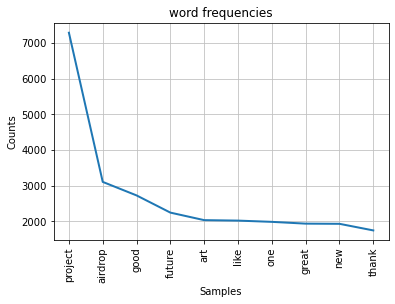

<AxesSubplot:title={'center':'word frequencies'}, xlabel='Samples', ylabel='Counts'>

In [121]:
TweetFreqs.plot(10, title='word frequencies')

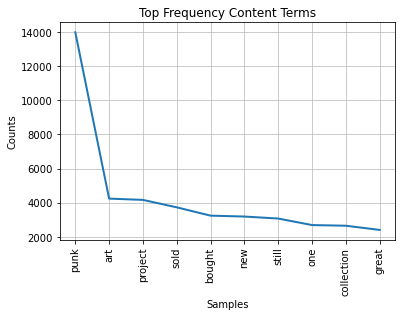

<AxesSubplot:title={'center':'Top Frequency Content Terms'}, xlabel='Samples', ylabel='Counts'>

In [58]:
TweetFreqs_CP.plot(10, title='Top Frequency Content Terms')

In [22]:
nft_df.to_pickle('nft_df.pkl')

In [59]:
cryptoPunks_df.to_pickle('cp_df.pkl')

In [24]:
from textblob import TextBlob

In [38]:
nft_df['likes_count'].sort_values(ascending=False)

30127    1186
48050    1129
35284    1110
39536    1042
17950     961
         ... 
33424       0
13048       0
13049       0
33420       0
0           0
Name: likes_count, Length: 50203, dtype: int64

In [39]:
nft_df.iloc[30127]

id                                               1417094945719128070
conversation_id                                  1417094945719128064
created_at                                 2021-07-19 08:12:18-04:00
date                                             2021-07-19 00:00:00
time                                                        08:12:18
timezone                                                        -400
user_id                                           877807935493033984
username                                                     binance
name                                                         Binance
place                                                               
tweet              Want to win this 4th-anniversary #BinanceFutur...
language                                                          en
mentions                                                          []
urls                                                              []
photos                            

In [40]:
cv_tfidf=TfidfVectorizer()

In [66]:
def vectorize_tfidf(df,cv_tfidf):
    corpus=df['tweet_clean'].tolist()
    cv_tfidf=TfidfVectorizer(stop_words="english")
    X_tfidf=cv_tfidf.fit_transform(corpus).toarray()
    dt_tfidf=pd.DataFrame(X_tfidf,columns=cv_tfidf.get_feature_names())
    return dt_tfidf,X_tfidf

In [67]:
dt_tfidf_nft,X_tfidf_nft=vectorize_tfidf(nft_df,cv_tfidf)
dt_tfidf_cp,X_tfidf_cp=vectorize_tfidf(cryptoPunks_df,cv_tfidf)

In [68]:
dt_tfidf_nft

,aa,abandon,abandoned,ability,able,abnormal,aboard,abreast,abroad,abruptly,...,zig,zip,zodiac,zoetrope,zombie,zone,zoning,zoo,zoom,zoomorphic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
dt_tfidf_cp

,aa,aba,abandon,abandoned,abdicate,abduct,abduction,abide,ability,ablaze,...,zimbabwe,zip,zipper,zodiac,zombi,zombie,zone,zoning,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
def display_nmf_topics(components,random_state,X,cv_tfidf):
    nmf = NMF(n_components=components, random_state=random_state)
    #nmf.fit(X_tfidf_nft)
    nmf.fit(X)
    for index,topic in enumerate(nmf.components_):
        print(f"The top 20 words for topic # {index}")
        print([cv_tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
        print("\n")
    return nmf

/Users/juju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The top 20 words for topic # 0
['believe', 'love', 'hopefully', 'like', 'join', 'amazing', 'success', 'really', 'opportunity', 'team', 'moon', 'future', 'giveaway', 'anonymous', 'best', 'hope', 'nice', 'great', 'airdrop', 'project']


The top 20 words for topic # 1
['friend', 'new', 'market', 'huge', 'collection', 'promising', 'giveaway', 'development', 'getting', 'art', 'best', 'hope', 'hi', 'sold', 'like', 'love', 'work', 'support', 'opportunity', 'thank']


The top 20 words for topic # 2
['going', 'inspiration', 'huge', 'giveaway', 'anonymous', 'hopefully', 'soon', 'growth', 'faster', 'team', 'dev', 'kudos', 'future', 'pretty', 'invest', 'worthy', 'gem', 'optimistic', 'definitely', 'airdrop']


The top 20 words for topic # 3
['like', 'wonderful', 'address', 'drop', 'man', 'amazing', 'collection', 'follow', 'support', 'advance', 'lot', 'giveaway', 'giving', 'new', 'art', 'love', 'check', 'great', 'opportunity', 'thanks']


The top 20 words for topic # 4
['hope', 'week', 'wish', 'futu

In [123]:
nmf.fit(X_tfidf_cp)

# display the result
for index,topic in enumerate(nmf.components_):
    print(f"The top 20 words for topic # {index}")
    print([cv_tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print("\n")

/Users/juju/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The top 20 words for topic # 0
['awesomely', 'strict', 'clink', 'suicidal', 'superb', 'bull', 'cava', 'kindly', 'fu', 'strike', 'open', 'lar', 'lark', 'restore', 'untimely', 'stubborn', 'crossroads', 'alphabet', 'poor', 'bong']


The top 20 words for topic # 1
['reasonable', 'clink', 'strict', 'grounded', 'civil', 'army', 'cancel', 'kindly', 'ethereal', 'antique', 'drop', 'obtain', 'bull', 'atop', 'fu', 'awesomely', 'vender', 'poor', 'lastly', 'structured']


The top 20 words for topic # 2
['liar', 'army', 'bell', 'relief', 'newsletter', 'estate', 'harmony', 'gatekeeper', 'atop', 'thrown', 'admired', 'fabulously', 'heavy', 'deserving', 'medication', 'modernism', 'manifest', 'tic', 'argument', 'serial']


The top 20 words for topic # 3
['cheaply', 'knockoff', 'prisoner', 'tested', 'synergy', 'depending', 'kukri', 'photographic', 'large', 'serial', 'belated', 'climb', 'mirror', 'relief', 'division', 'arse', 'execution', 'liar', 'authenticate', 'poor']


The top 20 words for topic # 4
['h

In [47]:
featnames=cv_tfidf.get_feature_names()

In [82]:
vals_cp=cryptoPunks_df.tweet.values
len(vals_cp)

50006

In [83]:
#pip install vaderSentiment

In [84]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

neg=[]
neu=[]
pos=[]
comp=[]

analyzer = SentimentIntensityAnalyzer()
for sentence in vals_cp:
    vs = analyzer.polarity_scores(sentence)
    _1,_2,_3,_4=vs.values()
    neg.append(_1)
    neu.append(_2)
    pos.append(_3)
    comp.append(_4)
    
cryptoPunks_df['neg'],cryptoPunks_df['neu'],cryptoPunks_df['pos'],cryptoPunks_df['compound'] =neg,neu,pos,comp

Text(0.5, 1.0, 'Sentiment Score')

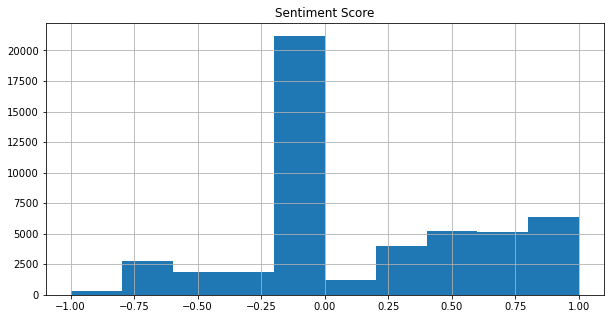

In [120]:
cryptoPunks_df['compound'].hist(figsize=(10,5))
plt.title('Sentiment Score')


In [86]:
cryptoPunks_df['compound'].mean()

0.18641949166100072

In [87]:
pos_df=cryptoPunks_df[cryptoPunks_df['compound']>0]
neg_df=cryptoPunks_df[cryptoPunks_df['compound']<0]

In [88]:
pos_idx=[int(i) for i in pos_df.index.values]
neg_idx=[int(i) for i in neg_df.index.values]

In [97]:
nft_df.created_at.value_counts

<bound method IndexOpsMixin.value_counts of 0       2021-07-19 16:41:47-04:00
1       2021-07-19 16:41:43-04:00
2       2021-07-19 16:41:43-04:00
3       2021-07-19 16:41:43-04:00
4       2021-07-19 16:41:41-04:00
                   ...           
50198   2021-07-18 22:21:56-04:00
50199   2021-07-18 22:21:52-04:00
50200   2021-07-18 22:21:51-04:00
50201   2021-07-18 22:21:51-04:00
50202   2021-07-18 22:21:44-04:00
Name: created_at, Length: 50203, dtype: datetime64[ns, pytz.FixedOffset(-240)]>

In [98]:
nft_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'tweet_clean', 'adjectives'],
      dtype='object')

In [144]:
nft_small=nft_df.drop(['id','conversation_id','timezone','user_id','retweet','video'],axis=1)
nft_small=nft_small.groupby(['username']).mean().sort_values(by=['likes_count'],ascending=False)

In [145]:
nft_small

,replies_count,retweets_count,likes_count
username,,,
ruffleycrypto,31.0,1189.0,1129.0
dj_crypto1,543.0,1849.0,1110.0
veve_official,181.0,416.0,961.0
apenftorg,153.0,188.0,839.0
pancakeswap,109.0,142.0,771.0
...,...,...,...
opeyemi37182654,0.0,0.0,0.0
ophinhung1,0.0,0.0,0.0
frankeinstein4k,0.0,0.0,0.0


In [115]:
cryptoPunks_df.geo.value_counts

<bound method IndexOpsMixin.value_counts of 0         
1         
2         
3         
4         
        ..
50001     
50002     
50003     
50004     
50005     
Name: geo, Length: 50006, dtype: object>

In [118]:
nft_df.to_csv('nft_df.csv')

In [119]:
cryptoPunks_df.to_csv('cp_df.csv')

In [135]:
punc=list(punctuation)

In [149]:
def clean_again(nft_df):
    nft_df['tweet2']=nft_df['tweet'].str.lower()
    nft_df['tweet2']=nft_df['tweet2'].apply(word_tokenize)
    nft_df['tweet2']=nft_df['tweet2'].apply(lambda x: [word for word in x if word not in stop_words])
    nft_df['tweet2']=nft_df['tweet2'].apply(lambda x: [word for word in x if word not in punc])
    nft_df['tweet2']=nft_df['tweet2'].apply(lambda x: list(set(x)))
    return nft_df['tweet2']

In [150]:
cryptoPunks_df['tweet2']=clean_again(cryptoPunks_df)

In [141]:
import itertools
from wordcloud import WordCloud
import random


def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

In [152]:
def produce_word_cloud(nft_df):
    lst = nft_df['tweet2'].tolist()
    lst = list(itertools.chain(*lst))
    description = ' '.join(lst)

    plt.figure(figsize=(16,12))
    wordcloud = WordCloud(background_color='white',max_font_size=50, max_words=100).generate(description)
    plt.imshow(wordcloud.recolor(color_func=blue_color_func, random_state=3),
               interpolation="bilinear")
    #plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

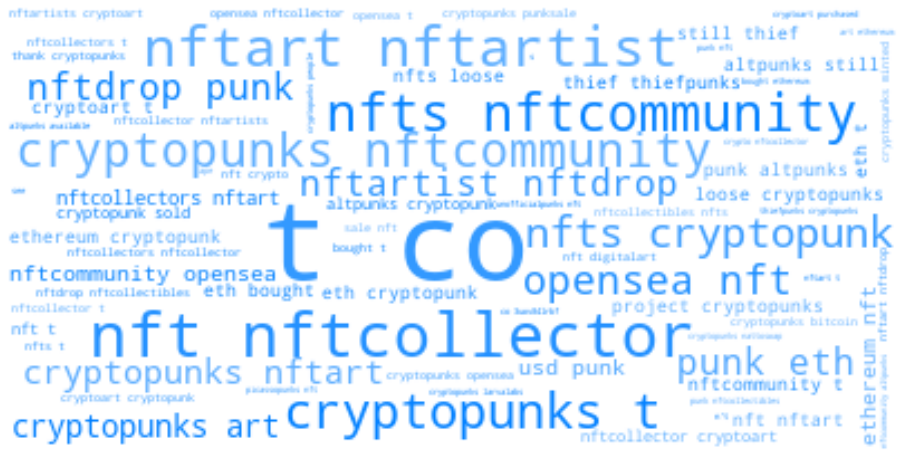

In [153]:
produce_word_cloud(cryptoPunks_df)

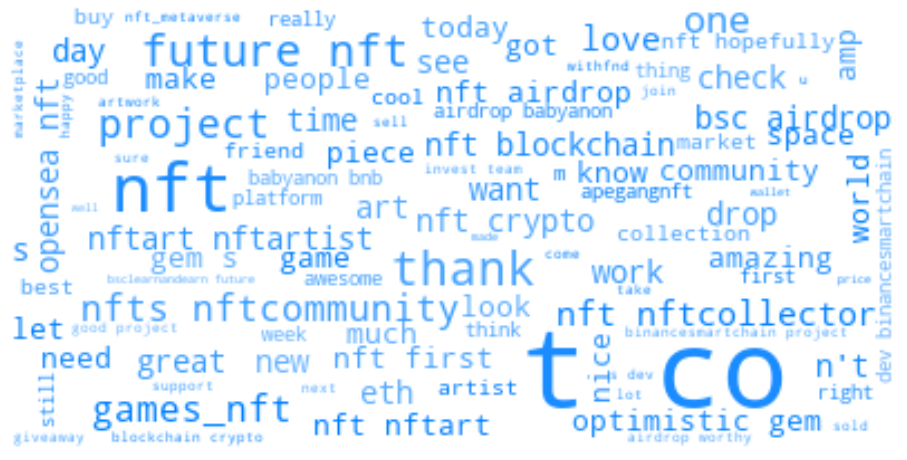

In [154]:
produce_word_cloud(nft_df)